# Initial Plan for RSNA Breast Cancer Detection

## Objectives
- Achieve a probabilistic F1 score >= 0.41 for bronze medal, aiming higher.
- Focus on robust CV, feature engineering from metadata, and image-based modeling.

## High-Level Strategy
1. **Environment Setup:** Verify GPU availability and install necessary packages (e.g., PyTorch with CUDA, pydicom, etc.).
2. **Data Exploration (EDA):** Load train.csv, analyze distributions (cancer rate, age, density, etc.), visualize sample mammograms.
3. **Data Pipeline:** Handle DICOM images, preprocess (resize, normalize), extract metadata features.
4. **Baseline Model:** Start with simple tabular model on metadata, then CNN on images (e.g., ResNet).
5. **Cross-Validation:** Use GroupKFold by patient_id to avoid leakage, evaluate with probabilistic F1.
6. **Iteration:** Feature engineering, model ensembling, aim for medal thresholds.
7. **Submission:** Predict on test, save to submission.csv.

## Next Steps
- Check GPU.
- Load and describe train.csv.
- Request expert review after EDA.

GPU Check Output:
Fri Sep 26 04:53:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.06             Driver Version: 550.144.06     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10-24Q                 On  |   00000002:00:00.0 Off |                    0 |
| N/A   N/A    P0             N/A /  N/A  |     182MiB /  24512MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------


Density value counts:
density
B    11379
C    10977
A     2798
D     1341
Name: count, dtype: int64

Cancer rate by view:
view
AT     0.000000
CC     0.020589
LM     0.000000
LMO    0.000000
ML     0.000000
MLO    0.020593
Name: cancer, dtype: float64



Patient-level cancer rate: 0.04001492398097192


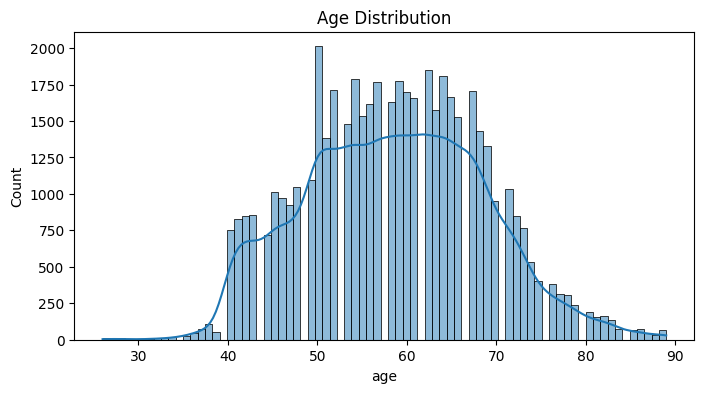

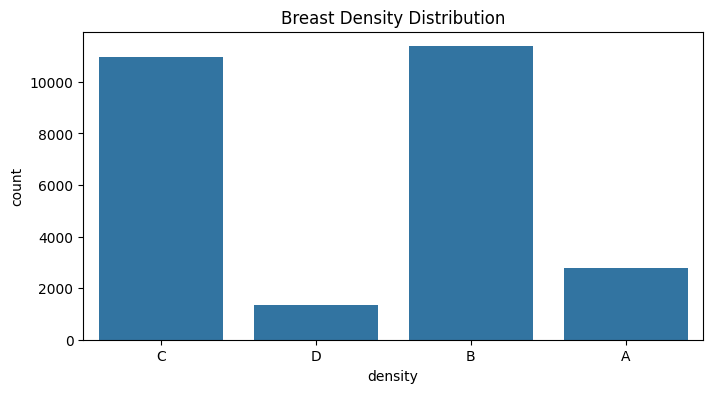

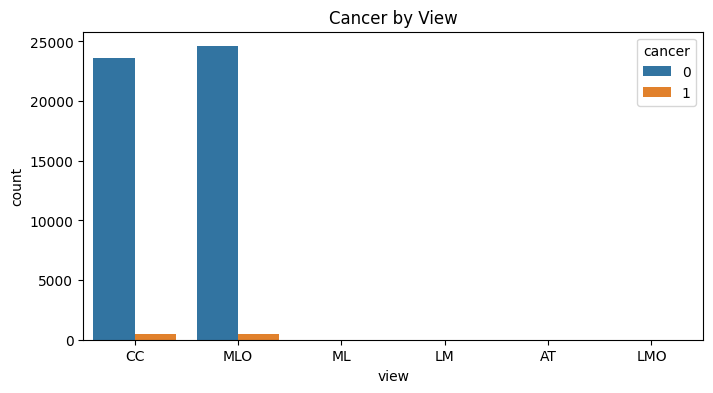

In [1]:
import subprocess
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check GPU availability
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print('GPU Check Output:')
print(result.stdout)
if result.returncode != 0:
    print('GPU not available! Exiting competition.')
    sys.exit(1)

# Load train.csv
train_df = pd.read_csv('train.csv')
print('Train dataset shape:', train_df.shape)
print('\nTrain dataset info:')
print(train_df.info())
print('\nFirst few rows:')
print(train_df.head())

# Basic statistics
print('\nCancer rate:', train_df['cancer'].mean())
print('\nValue counts for cancer:')
print(train_df['cancer'].value_counts(normalize=True))

# Check for missing values
print('\nMissing values:')
print(train_df.isnull().sum())

# Age distribution
if 'age' in train_df.columns:
    print('\nAge statistics:')
    print(train_df['age'].describe())
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df['age'].dropna(), kde=True)
    plt.title('Age Distribution')
    plt.show()

# Density distribution
if 'density' in train_df.columns:
    print('\nDensity value counts:')
    print(train_df['density'].value_counts())
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_df, x='density')
    plt.title('Breast Density Distribution')
    plt.show()

# Cancer by side
if 'side' in train_df.columns:
    print('\nCancer rate by side:')
    print(train_df.groupby('side')['cancer'].mean())
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x='side', hue='cancer')
    plt.title('Cancer by Side')
    plt.show()

# Cancer by view
if 'view' in train_df.columns:
    print('\nCancer rate by view:')
    print(train_df.groupby('view')['cancer'].mean())
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_df, x='view', hue='cancer')
    plt.title('Cancer by View')
    plt.show()

# Patient-level cancer rate
patient_cancer = train_df.groupby('patient_id')['cancer'].any()
print('\nPatient-level cancer rate:', patient_cancer.mean())

## Updated Plan Based on Expert Review

### Key Insights from EDA and Experts
- GPU: A10-24Q available, CUDA 12.4 (install PyTorch cu121 for compatibility).
- Data: 49k images, 2% cancer (imbalanced), patient-level 4%; missing age/BIRADS/density; exclude biopsy/invasive to avoid leakage.
- Medal Strategy: Image-first with CNNs (timm EfficientNet/ConvNeXt); metadata secondary. Target pF1 >=0.41.
- Common Pitfalls: Patient leakage, improper DICOM handling (VOI LUT, inversion), low-res inputs (<512px), optimizing wrong metric.

### Revised High-Level Strategy
1. **Setup:** Install PyTorch cu121, pydicom, timm, albumentations, scikit-learn. Verify DICOM loading.
2. **Preprocessing Pipeline:** Load DICOMs with pydicom (apply VOI LUT, Rescale, invert MONOCHROME1, percentile clip, resize to 512px grayscale). Sanity-check visuals on samples.
3. **CV Setup:** StratifiedGroupKFold (5 folds) by patient_id, stratify on patient-level cancer. Implement probabilistic F1 metric.
4. **Baseline Model:** CNN (tf_efficientnet_b4_ns, in_chans=1) with BCEWithLogitsLoss (pos_weight ~48), light augs. Train on subsample first (e.g., 10% positive patients).
5. **Multi-View Aggregation:** Max prob across patient's images per breast/patient for OOF and submission.
6. **Iteration:** Scale to 768px, add TTA, ensemble 2 models, calibrate with temperature scaling for pF1. Add safe metadata (age, density, etc.) via stacking.
7. **Milestones:**
   - Verify pipeline & CV (pF1 dummy >0).
   - Baseline CNN OOF pF1 >=0.35 (subsample).
   - Full train, aggregate, submit for >=0.41.

### Next Immediate Steps
- Install packages.
- Verify DICOM paths and load sample images.
- Request expert review after pipeline sanity check.

In [3]:
import subprocess
import sys
import os
from pathlib import Path
import shutil

def pip_install(*args):
    print('>', *args, flush=True)
    subprocess.run([sys.executable, '-m', 'pip', *args], check=True)

# Clean previous torch installations
for pkg in ('torch', 'torchvision', 'torchaudio'):
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y', pkg], check=False)

# Clean stray directories
stray_dirs = [
    '/app/.pip-target/torch',
    '/app/.pip-target/torch-2.8.0.dist-info',
    '/app/.pip-target/torch-2.4.1.dist-info',
    '/app/.pip-target/torchvision',
    '/app/.pip-target/torchvision-0.23.0.dist-info',
    '/app/.pip-target/torchvision-0.19.1.dist-info',
    '/app/.pip-target/torchaudio',
    '/app/.pip-target/torchaudio-2.8.0.dist-info',
    '/app/.pip-target/torchaudio-2.4.1.dist-info',
    '/app/.pip-target/torchgen',
    '/app/.pip-target/functorch'
]
for d in stray_dirs:
    if os.path.exists(d):
        print('Removing', d)
        shutil.rmtree(d, ignore_errors=True)

# Install PyTorch cu121
pip_install(
    'install',
    '--index-url', 'https://download.pytorch.org/whl/cu121',
    '--extra-index-url', 'https://pypi.org/simple',
    'torch==2.4.1', 'torchvision==0.19.1', 'torchaudio==2.4.1'
)

# Create constraints file
constraints_path = Path('constraints.txt')
constraints_path.write_text(
    'torch==2.4.1\n'
    'torchvision==0.19.1\n'
    'torchaudio==2.4.1\n'
)

# Install other packages
pip_install(
    'install',
    '-c', 'constraints.txt',
    'pydicom',
    'timm',
    'albumentations',
    'scikit-learn',
    'opencv-python',
    'pillow'
)

# Verify PyTorch installation
import torch
print('PyTorch version:', torch.__version__)
print('CUDA version:', torch.version.cuda)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU device:', torch.cuda.get_device_name(0))
assert torch.cuda.is_available(), 'CUDA not available after installation'

print('Package installation completed successfully.')

> install --index-url https://download.pytorch.org/whl/cu121 --extra-index-url https://pypi.org/simple torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1


Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.org/simple


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 323.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 532.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 517.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 217.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 438.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 434.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 285.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 104.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 336.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 137.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 117.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 276.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 173.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 165.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 357.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 156.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 193.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 51.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 137.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 174.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 141.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 207.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 524.6 MB/s eta 0:00:00


> install -c constraints.txt pydicom timm albumentations scikit-learn opencv-python pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 125.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 KB 524.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 181.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 195.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 472.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 192.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 KB 278.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 KB 521.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 KB 213.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 82.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 354.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.9/444.9 KB 504.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 204.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 133.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.5/496.5 KB 459.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 258.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 KB 488.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 206.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 212.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 388.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 505.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 479.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 442.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 KB 331.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 KB 410.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 429.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 186.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 467.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 427.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 156.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 219.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 150.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 209.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 KB 464.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 159.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 192.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 133.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 174.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 216.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 469.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 458.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 198.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 KB 397.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 KB 471.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 KB 415.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 KB 460.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 367.2 MB/s eta 0:00:00


PyTorch version: 2.4.1+cu121
CUDA version: 12.1
CUDA available: True
GPU device: NVIDIA A10-24Q
Package installation completed successfully.


In [10]:
import subprocess
import sys
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Fix OpenCV import by installing headless version (no GUI deps)
subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y', 'opencv-python'], check=False)
subprocess.run([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless'], check=True)

import cv2

def load_dicom_image(path, size=512):
    ds = pydicom.dcmread(path, force=True)
    img = apply_voi_lut(ds.pixel_array, ds).astype(np.float32)
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * float(ds.RescaleSlope) + float(ds.RescaleIntercept)
    if ds.PhotometricInterpretation == 'MONOCHROME1':
        img = img.max() - img

    # Orientation normalize (optional: flip right breasts)
    lat = (ds.get('Laterality') or ds.get('ImageLaterality') or 'L')
    if lat == 'R':
        img = np.fliplr(img).copy()

    # ROI mask on uint8
    u8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, th = cv2.threshold(u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
        img = img[y:y+h, x:x+w]

    # Pad to square
    h,w = img.shape
    if h != w:
        m = max(h,w)
        top = (m-h)//2; bottom = m-h-top
        left = (m-w)//2; right = m-w-left
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(img.min()))

    # Percentile normalize after crop
    p0, p99 = np.percentile(img, (0.5, 99.5))
    img = np.clip((img - p0) / (p99 - p0 + 1e-6), 0, 1)

    # Resize
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LANCZOS4)
    return img.astype(np.float32)

# Find sample images from first patient
first_patient = train_df['patient_id'].iloc[0]
sample_rows = train_df[train_df['patient_id'] == first_patient].head(3)
sample_paths = []
for _, row in sample_rows.iterrows():
    image_path = Path('train_images') / str(row['patient_id']) / f"{row['image_id']}.dcm"
    if image_path.exists():
        sample_paths.append(image_path)

print(f'Found {len(sample_paths)} sample DICOM files for patient {first_patient}')

# Load and visualize samples
fig, axes = plt.subplots(2, len(sample_paths), figsize=(5*len(sample_paths), 10))
if len(sample_paths) == 1:
    axes = axes.reshape(2, -1)

for i, path in enumerate(sample_paths):
    # Original
    ds = pydicom.dcmread(path, force=True)
    orig_img = ds.pixel_array
    axes[0, i].imshow(orig_img, cmap='gray')
    axes[0, i].set_title(f'Original {path.name}')
    axes[0, i].axis('off')
    
    # Processed
    proc_img = load_dicom_image(path)
    axes[1, i].imshow(proc_img, cmap='gray')
    axes[1, i].set_title(f'Processed {path.name}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print('Updated DICOM loading and preprocessing pipeline (with ROI crop) sanity-checked.')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 483.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 202.9 MB/s eta 0:00:00


Found 3 sample DICOM files for patient 10006


Updated DICOM loading and preprocessing pipeline (with ROI crop) sanity-checked.


In [11]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

def make_folds(df, n_splits=5, seed=42):
    df = df.copy()
    pat_has_cancer = df.groupby('patient_id')['cancer'].any().astype(int)
    strata = df['patient_id'].map(pat_has_cancer).values
    groups = df['patient_id'].values
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    df['fold'] = -1
    for f, (_, val_idx) in enumerate(sgkf.split(df, strata, groups)):
        df.loc[df.index[val_idx], 'fold'] = f
    return df

def probabilistic_f1(y_true, y_prob):
    y_true = np.asarray(y_true, np.float32)
    y_prob = np.clip(np.asarray(y_prob, np.float32), 0, 1)
    tp = (y_true * y_prob).sum()
    return float((2.0 * tp) / (y_true.sum() + y_prob.sum() + 1e-15))

def pf1_patient_level(df, probs):
    tmp = df[['patient_id','cancer']].copy()
    tmp['prob'] = probs
    y_true = tmp.groupby('patient_id')['cancer'].max().values
    y_prob = tmp.groupby('patient_id')['prob'].max().values  # max over images per patient
    return probabilistic_f1(y_true, y_prob)

def make_quick_subsample(df, seed=42):
    pat_y = df.groupby('patient_id')['cancer'].max()
    pos_ids = pat_y[pat_y == 1].index
    neg_ids = pat_y[pat_y == 0].sample(len(pos_ids), random_state=seed).index
    keep = set(pos_ids) | set(neg_ids)
    return df[df['patient_id'].isin(keep)].copy()

# Filter to CC/MLO views only
train_df = train_df[train_df['view'].isin(['CC', 'MLO'])].copy()
print('Filtered train_df shape:', train_df.shape)

# Apply folds
train_df = make_folds(train_df)
print('Fold distribution:')
print(train_df['fold'].value_counts().sort_index())

# Create subsample
subsample = make_quick_subsample(train_df)
print('Subsample shape:', subsample.shape)
print('Subsample cancer rate:', subsample['cancer'].mean())

# Dummy test
dummy_probs = np.random.uniform(0, 1, len(subsample))
print('Image-level dummy pF1:', probabilistic_f1(subsample['cancer'].values, dummy_probs))
print('Patient-level dummy pF1:', pf1_patient_level(subsample, dummy_probs))

Filtered train_df shape: (49197, 14)


Fold distribution:
fold
0    9822
1    9803
2    9814
3    9851
4    9907
Name: count, dtype: int64
Subsample shape: (3992, 15)
Subsample cancer rate: 0.2537575150300601
Image-level dummy pF1: 0.33983032105696365
Patient-level dummy pF1: 0.6306250830279525
